In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from palettable.cartocolors.qualitative import Antique_10

from tqdm.auto import tqdm

from paiskintonetools import setup_matplotlib

setup_matplotlib(dpi=200)

In [2]:
from matplotlib.transforms import Bbox, TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxConnector,
    BboxConnectorPatch,
    BboxPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1,
        bbox2,
        loc1=loc1a,
        loc2=loc2a,
        clip_on=False,
        **prop_lines,
        in_layout=False,
    )
    c2 = BboxConnector(
        bbox1,
        bbox2,
        loc1=loc1b,
        loc2=loc2b,
        clip_on=False,
        **prop_lines,
        in_layout=False,
    )

    bbox_patch1 = BboxPatch(bbox1, **prop_patches, in_layout=False)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches, in_layout=False)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        clip_on=False,
        **prop_patches,
        in_layout=False,
    )

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both Axes will
    be marked.

    Parameters
    ----------
    ax1
        The main Axes.
    ax2
        The zoomed Axes.
    xmin, xmax
        The limits of the colored area in both plot Axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, ax1.get_xaxis_transform())
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=2,
        loc1b=4,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

In [3]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [4]:
import patato as pat
from pathlib import Path

In [5]:
measurements = []
regions = ["Neck", "Forearm", "Bicep", "Leg"]

i = 0
files = list(Path("../Data").glob("**/*.hdf5"))
for f in tqdm(files):
    if "Scan_1.hdf5" == f.name:
        continue
    p = pat.PAData.from_hdf5(f)
    if (
        "phantom" in p.get_scan_name()
        or not any([x.lower() in p.get_scan_name() for x in regions])
        or "error" in p.get_scan_name().lower()
    ):
        continue
    m = {}
    m["SkinID"] = f.parent.stem
    sites = [x for x in regions if x.lower() in p.get_scan_name()]
    assert len(sites) == 1
    m["Site"] = sites[0]
    cropped = p.get_time_series().raw_data[:, :, :, 250:]
    m["Wavelengths"] = p.get_wavelengths()
    m["Max"] = np.max(cropped, axis=(0, 2, 3))
    m["Min"] = np.min(cropped, axis=(0, 2, 3))
    m["FractionClipped"] = np.mean(cropped == 4095, axis=(0, 2, 3))
    m["FractionClipped"] += np.mean(cropped == 0, axis=(0, 2, 3))
    i += 1
    measurements.append(m)

df = pd.DataFrame(measurements)
df = df.explode(["Wavelengths", "Max", "Min", "FractionClipped"], ignore_index=False)

df["Wavelengths"] = df["Wavelengths"].astype(int)
df["Label"] = df["Site"]
df["AnyClipping"] = df["FractionClipped"] > 0
del df["Site"]
df = df.groupby(["SkinID", "Label", "Wavelengths"]).mean().reset_index()

df_ita = pd.read_parquet("../01_Prepare Data/ITA_raw.parquet")
regions = {"Radial Artery": "Forearm", "Carotid Artery": "Neck"}
df_ita["Label"] = df_ita["Region"].apply(lambda x: regions.get(x, x))

df_full = df_ita[["SkinID", "Label", "ITA"]].merge(df, on=["SkinID", "Label"])

  0%|          | 0/201 [00:00<?, ?it/s]

In [6]:
df_full.to_parquet("timeseries_clipping_output.parquet")

980
1030
1080
1100
1210


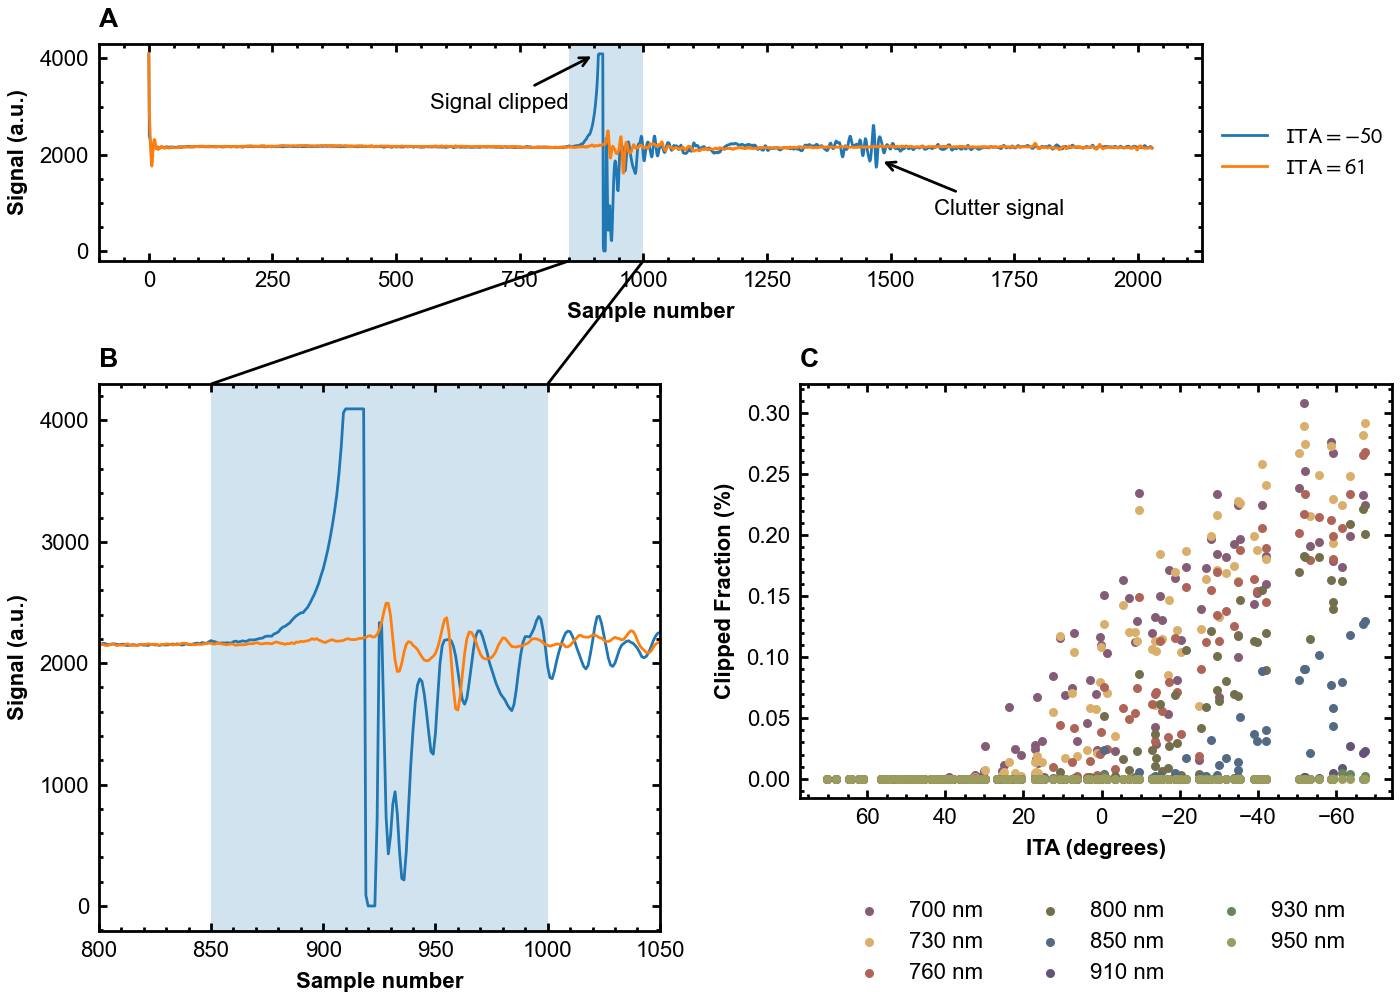

In [ ]:
fig = plt.figure(figsize=(7, 5), layout="constrained")


def custom_transform(x, y=0):
    return ScaledTranslation(-x / 4, -y / 4, fig.dpi_scale_trans)


sfa, sfb = fig.subfigures(2, height_ratios=[1, 2])

sfb_1, sfb_2 = sfb.subfigures(1, 2)
ax3 = sfb_2.subplots()
ax2 = sfb_1.subplots()
ax1 = sfa.subplots()

ita_new = np.linspace(np.min(df_full["ITA"]), np.max(df_full["ITA"]), 200)[1:-1]

df_full = df_full.sort_values(["SkinID", "Wavelengths"])

i = 0
for n, g in df_full.groupby("Wavelengths"):
    x = g["ITA"].values
    y = g["FractionClipped"].astype(float).values * 100

    if np.all(y == 0):
        print(n)
        continue
    ax3.scatter(x, y, color=Antique_10.mpl_colors[i], label=f"{n} nm", s=5)
    i += 1

ax3.invert_xaxis()
ax3.set_xlabel("ITA (degrees)")
ax3.set_ylabel("Clipped Fraction (%)")
ax3.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncols=3)
ax3.set_title("C", loc="left", fontweight="bold")

p = pat.PAData.from_hdf5("../Data/SKIN19/Scan_2.hdf5")
p2 = pat.PAData.from_hdf5(
    "../Data/SKIN01/Scan_4.hdf5"
)  # N.b. Scan_5 used in paper, but not in exemplar dataset. Again, there is absolutely no difference. This is just recorded for completeness.

ax1.plot(p.get_time_series()[0, 0, 128].raw_data, label=r"$\mathrm{ITA = -50}$")
ax1.plot(p2.get_time_series()[0, 0, 128].raw_data, label=r"$\mathrm{ITA = 61}$")
ax1.set_xlabel("Sample number")
ax1.set_ylabel("Signal (a.u.)")
ax1.set_title("A", loc="left", fontweight="bold")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))

zoom_effect01(ax1, ax2, 850, 1000)
ax2.plot(p.get_time_series()[0, 0, 128].raw_data)
ax2.plot(p2.get_time_series()[0, 0, 128].raw_data)
ax2.set_xlim([800, 1050])
ax2.set_xlabel("Sample number")
ax2.set_ylabel("Signal (a.u.)")
ax2.set_title("B", loc="left", fontweight="bold")
ax1.annotate(
    "Signal clipped",
    (905, 4095),
    (-60, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

ax1.annotate(
    "Clutter signal",
    (1475, 1900),
    (20, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)
fig.savefig("figures/sfigure_timeseries.pdf", dpi=300)
plt.show()